<a href="https://colab.research.google.com/github/srivastavanishtha/amazon-retail-case-study/blob/main/Retail_Analysis_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline Code Description

#### 1. Data Loading and Exploration:
- The code imports the necessary libraries, loads the dataset from a csv, and prints the first few rows and information about the dataset to understand its structure.

In [1]:
# Step 1: Data Exploration
import pandas as pd

# Load the dataset from a CSV file
data = pd.read_csv('amazon_product_data.csv')

# Display the first few rows and information about the dataset
print("First 5 rows of the dataset:")
print(data.head())
print("\nDataset Information:")
print(data.info())

First 5 rows of the dataset:
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   
3  Computers&Accessories|Accessories&Peripherals|...             ₹329   
4  Computers&Accessories|Accessories&Peripherals|...             ₹154   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.2       24,269   
1      

#### 2.1 Handling Missing Data:
- The code checks for missing values in the dataset. It fills missing ratings with the median value and replaces missing review contents with "No Review".

In [2]:
# Step 2: Data Preprocessing
# Check for missing values in each column
missing_data = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_data)


Missing values in each column:
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64


In [3]:
# Filling missing values
# Filling 'rating' with its median as it is a numerical column
# Convert 'rating' column to numeric type, handling errors
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')
data['rating'].fillna(data['rating'].median(), inplace=True)

# Filling 'review_content' with "No Review" for missing reviews
data['review_content'].fillna("No Review", inplace=True)

#### 2.2. Text Cleaning and Translation:
- A function is defined to clean the review text by removing special characters and translating any non-English text to English using TextBlob. This ensures uniformity in the text data.

In [4]:
# Importing required libraries for text processing
import re
from textblob import TextBlob

# Function to clean and translate text
def clean_and_translate(text):
    # Remove special characters and numbers, retaining only alphabetic characters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    try:
        # Attempt to translate the text
        translated = str(TextBlob(text).translate(to='en'))
    except AttributeError:
        # If translation fails and returns a list, join it into a string
        # or handle it in another way that makes sense for your data
        if isinstance(text, list):
            translated = ' '.join(text)
        else:
            # If it's not a list and still caused an error,
            # you might want to keep the original text or handle it differently
            translated = text

    return translated

# Apply cleaning and translation on review_content
data['review_content'] = data['review_content'].apply(clean_and_translate)

#### 3. Sentiment Analysis:
- Another function is defined to analyze the sentiment of each review content, categorizing them into positive, neutral, or negative based on the sentiment polarity score.

In [5]:
# Step 3: Sentiment Analysis
def get_sentiment(text):
    # Analyze sentiment polarity: positive (>0), neutral (=0), negative (<0)
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis function to the review content
data['sentiment'] = data['review_content'].apply(get_sentiment)

#### 4. Data Visualization:
- The code uses Seaborn to visualize the distribution of sentiments across the dataset, providing insights into customer feedback trends.

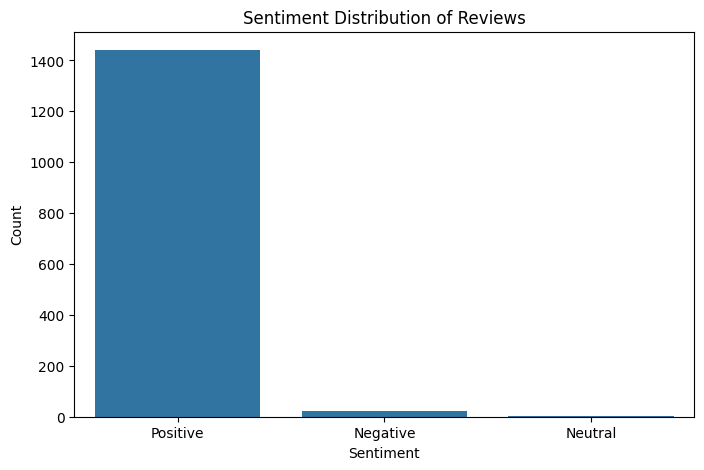

In [6]:
# Step 4: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


#### 5. Modeling:
- The sentiment labels are encoded into numerical format for machine learning. The dataset is split into training and testing sets. A tokenizer converts the text reviews into sequences of integers, and these sequences are padded to ensure uniform input size.
- An LSTM neural network model is constructed, compiled, and trained on the padded sequences, which allows it to learn from the sentiment of the reviews.

In [7]:
# !pip install textblob keras
# The keras.preprocessing.text module has changed its location from keras library.
# Now, it resides within tensorflow.keras.preprocessing module.

In [8]:
# Step 5: Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# Import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences from tensorflow.keras.preprocessing.sequence

# Encode the sentiment labels to numerical format
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

# Splitting the dataset into training and testing sets (80% train, 20% test)
X = data['review_content']  # Features: review content
y = data['sentiment_encoded']  # Labels: encoded sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization: Convert text to sequences of integers
tokenizer = Tokenizer(num_words=5000)  # Limit to the top 5000 words
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer on training data
X_train_seq = tokenizer.texts_to_sequences(X_train)  # Convert training reviews to sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convert testing reviews to sequences

# Padding sequences to ensure uniform input size (max length of 100)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Building a simple LSTM model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))  # Embedding layer for word representation
model.add(SpatialDropout1D(0.2))  # Dropout to prevent overfitting
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer with dropout
model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes (Positive, Neutral, Negative)

# Compile the model with loss function and optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# Step 6: Insights and Conclusion
print("\nModel Training Complete!")

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - accuracy: 0.8509 - loss: 0.8425 - val_accuracy: 0.9898 - val_loss: 0.0676
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.9798 - loss: 0.1233 - val_accuracy: 0.9898 - val_loss: 0.0620
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.9822 - loss: 0.0945 - val_accuracy: 0.9898 - val_loss: 0.0593
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.9776 - loss: 0.1126 - val_accuracy: 0.9898 - val_loss: 0.0582
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.9800 - loss: 0.1015 - val_accuracy: 0.9898 - val_loss: 0.0593

Model Training Complete!
